# Differential Privacy

```{admonition} Learning Objectives
After reading this chapter, you will be able to:

- Define differential privacy
- Explain the importance of the privacy parameter $\epsilon$
- Use the Laplace mechanism to enforce differential privacy for counting queries
```

Like $k$-Anonymity, *differential privacy* {cite}`dwork2006A,dwork2006B` is a formal notion of privacy (i.e. it's possible to prove that a data release has the property). Unlike $k$-Anonymity, however, differential privacy is a property of *algorithms*, and not a property of *data*. That is, we can prove that an *algorithm* satisfies differential privacy; to show that a *dataset* satisfies differential privacy, we must show that the algorithm which produced it satisfies differential privacy.

It is first important to know that two datasets are considered *neighbors* if they differ in the data of a *single individual*.


```{prf:definition} Privacy Mechanism
:label: mechanism
A function which satisfies differential privacy is often called a *mechanism*. We say that a *mechanism* $F$ satisfies $\epsilon$-differential privacy if for all *neighboring datasets* $x$ and $x'$, and all possible sets of outputs $S$ (where $S$ refers to “sets $S$ of outputs of the mechanism.”)

\begin{equation}
\frac{\mathsf{Pr}[F(x) \in S]}{\mathsf{Pr}[F(x') \in S]} \leq e^\epsilon
\end{equation}

The $\epsilon$ parameter in the definition is called the *privacy parameter* or the *privacy budget*. $\epsilon$ provides a knob to tune the "amount of privacy" the definition provides. Small values of $\epsilon$ require $F$ to provide *very* similar outputs when given similar inputs, and therefore provide higher levels of privacy; large values of $\epsilon$ allow less similarity in the outputs, and therefore provide less privacy. 
```

Note that $F$ is typically a *randomized* function, which has many possible outputs under the same input. Therefore, the probability distribution describing its outputs is not just a point distribution.

In the definition of ε-differential privacy, the *probability is taken over the randomness of the algorithm itself*—that is, over the internal randomness used by the privacy mechanism to produce an output.

The important implication of this definition is that $F$'s output will be pretty much the same, *with or without* the data of any specific individual. In other words, the randomness built into $F$ should be "enough" so that an observed output from $F$ will not reveal which of $x$ or $x'$ was the input. Imagine that my data is present in $x$ but not in $x'$. If an adversary can't determine which of $x$ or $x'$ was the input to $F$, then the adversary can't tell whether or not my data was *present* in the input - let alone the contents of that data.


How should we set $\epsilon$ to prevent bad outcomes in practice? Nobody knows. The general consensus is that $\epsilon$ should be around 1 or smaller, and values of $\epsilon$ above 10 probably don't do much to protect privacy - but this rule of thumb could turn out to be very conservative. We will have more to say on this subject later on.

```{note}
Why is $S$ a set, and why do we write $F(x) \in S$, instead of $F(x) = s$ for a *single* output $s$? When $F$ returns elements from a continuous domain (like the real numbers), then the probability $\mathsf{Pr}[F(x) = S] = 0$ *for all $x$* (this is a property of continuous probability distributions---[see here for a detailed explanation](https://www.probabilitycourse.com/chapter4/4_1_1_pdf.php)). For the definition to make sense in the context of continuous distributions, it needs to instead consider *sets* of outputs $S$, and use set inclusion ($\in$) instead of equality. 

If $F$ returns elements of a discrete set (e.g. 32-bit floating-point numbers), then the definition can instead consider $S$ to be a single value, and use equality instead of set inclusion:

\begin{equation}
\frac{\mathsf{Pr}[F(x) = S]}{\mathsf{Pr}[F(x') = S]} \leq e^\epsilon
\end{equation}

This definition might be more intuitive, especially if you have not studied probability theory.
```

## The Laplace Mechanism

Differential privacy is typically used to answer specific queries. Let's consider a query on the census data, *without* differential privacy.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-whitegrid')
adult = pd.read_csv("adult_with_pii.csv")

"How many individuals in the dataset are 40 years old or older?"

In [2]:
adult[adult['Age'] >= 40].shape[0]

17450

The easiest way to achieve differential privacy for this query is to add random noise to its answer. The key challenge is to add enough noise to satisfy the definition of differential privacy, but not so much that the answer becomes too noisy to be useful. To make this process easier, some basic *mechanisms* have been developed in the field of differential privacy, which describe exactly what kind of - and how much - noise to use. One of these is called the *Laplace mechanism* {cite}`dwork2006B`.

```{prf:definition} Laplace Mechanism
:label: laplace
According to the Laplace mechanism, for a function $f(x)$ which returns a number, the following definition of $F(x)$ satisfies $\epsilon$-differential privacy:

\begin{equation}
F(x) = f(x) + \textsf{Lap}\left(\frac{s}{\epsilon}\right)
\end{equation}

where $s$ is the *sensitivity* of $f$, and $\textsf{Lap}(S)$ denotes sampling from the Laplace distribution with center 0 and scale $S$.

The probability density function (PDF) of the Laplace distribution is 

\begin{equation}
f(x) = \frac{1}{2S} \exp\left(-\frac{|x|}{S}\right)
\end{equation}

```

The **Sensitivity** of a function $f$ is the amount $f$'s output changes when its input changes in a minimal way. Intuitively, for a simple function with one numeric input, we think of the scenario where the input increases or decreases (changes) by 1. 

However, more generally, define it in terms of **adjacent dataset inputs**.

Two datasets are said to be **adjacent** if they differ in the data of exactly **one individual**. This could mean adding or removing a single row (in the *add-remove* model) or changing a single row (in the *substitution* model). This notion of adjacency defines the smallest possible difference between datasets, and it forms the basis for reasoning about privacy guarantees.

The **global sensitivity** of a function $f$ is then generally defined as the maximum amount its output can change between any input pair of adjacent datasets.

Sensitivity is a complex topic, and an integral part of designing differentially private algorithms; we will have much more to say about it later. For now, we will just point out that **counting queries** always have a sensitivity of **1**: if a query counts the number of rows in the dataset with a particular property, and then we modify exactly one row of the dataset, then the query's output can change by at most **1**.

Thus we can achieve differential privacy for our example query by using the Laplace mechanism with sensitivity 1 and an $\epsilon$ of our choosing. For now, let's pick $\epsilon = 0.1$. We can sample from the Laplace distribution using Numpy's `random.laplace`.

In [4]:
sensitivity = 1
epsilon = 0.1

adult[adult['Age'] >= 40].shape[0] + np.random.laplace(loc=0, scale=sensitivity/epsilon)

17456.974611712765

You can see the effect of the noise by running this code multiple times. Each time, the output changes, but most of the time, the answer is close enough to the true answer (14,235) to be useful.

In [ ]:
Draw sample for sidtribution. Display the histogram of the samples, along with the probability density function:

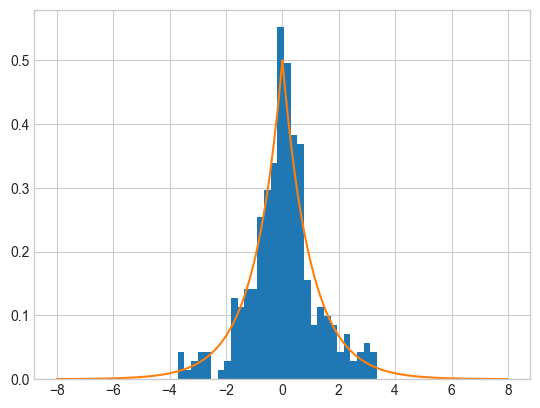

In [10]:
import matplotlib.pyplot as plt
loc, scale = 0., 1.
s = np.random.laplace(loc, scale, 300)
count, bins, ignored = plt.hist(s, 30, density=True)
x = np.arange(-8., 8., .01)
pdf = np.exp(-abs(x-loc)/scale)/(2.*scale)
plt.plot(x, pdf)

In [ ]:
Plot gaussian for comparison


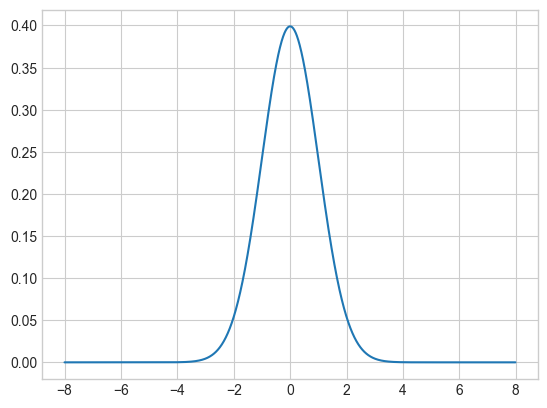

In [7]:
g = (1/(scale * np.sqrt(2 * np.pi)) *
     np.exp(-(x - loc)**2 / (2 * scale**2)))
plt.plot(x,g)

## How Much Noise is Enough?

How do we know that the Laplace mechanism adds enough noise to prevent the re-identification of individuals in the dataset? For one thing, we can try to break it! Let's write down a malicious counting query, which is specifically designed to determine whether Karrie Trusslove has an income greater than \$50k.

In [11]:
karries_row = adult[adult['Name'] == 'Karrie Trusslove']
karries_row[karries_row['Target'] == '<=50K'].shape[0]

1

This result definitely violates Karrie's privacy, since it reveals the value of the income column for Karrie's row. Since we know how to ensure differential privacy for counting queries with the Laplace mechanism, we can do so for this query:

In [20]:
sensitivity = 1
epsilon = 0.1

karries_row = adult[adult['Name'] == 'Karrie Trusslove']
karries_row[karries_row['Target'] == '<=50K'].shape[0] + \
  np.random.laplace(loc=0, scale=sensitivity/epsilon)

-2.9692295436403575

Is the true answer 0 or 1? There's too much noise to be able to reliably tell. This is how differential privacy is *intended* to work - the approach does not *reject* queries which are determined to be malicious; instead, it adds enough noise that the results of a malicious query will be useless to the adversary.

```{note}
**Randomness and Replicability**

Some examples in this book use randomized algorithms, particularly when demonstrating differentially private mechanisms that add noise to data or model updates. Because we do not fix a random seed, the exact output of these examples will vary from one run to another. This variability is expected and is a natural consequence of differential privacy, which depends on randomness to provide protection.

If your results differ slightly from those shown in the book, that’s not a bug—it’s a feature. The underlying behavior of the algorithm should remain consistent, even if the exact numbers vary. If you need to replicate results exactly (for testing or debugging), you can set a fixed seed using tools like `np.random.seed()` or `random.seed()` in Python. For instructional purposes, however, we choose not to fix seeds so that the examples reflect the true behavior of private algorithms in practice.

```

## The Unit of Privacy

The typical definition of differential privacy defines *neighboring datasets* as any two datasets that differ in "one person's data." It's often difficult or impossible to figure out how much data "belongs" to which person.

The *unit of privacy* refers to the formal definition of "neighboring" used in a differential privacy guarantee. The most common unit of privacy is "one person" - meaning the privacy guarantee protects the whole person, forever. This is also commonly referred to as “user-level privacy”. 

But other definitions are possible; [Apple's implementation of differential privacy](https://www.apple.com/privacy/docs/Differential_Privacy_Overview.pdf), for example, uses a "person-day" unit of privacy, meaning that the guarantee applies to the data submitted by one person on a single day.

The unit of privacy can result in surprising privacy failures. For example, in Apple's system, the differential privacy guarantee does *not* protect trends in the data occurring across multiple days - even for individual people. If a person submits identical data for 365 days in a row, then differential privacy provides essentially no protection for that data.

The "one person" unit of privacy is a good default, and usually avoids surprises. Other units of privacy are usually used to make it easier to get accurate results, or because it's hard to tie specific data values to individual people.

It's common to make a simplifying assumption that makes it easy to formalize the definition of neighboring datasets:
- **Each individual's data is contained in exactly one row of the data**

If this assumption is true, then it's possible to define neighboring datasets formally, in terms of the format of the data (see below), and retain the desired "one person" unit of privacy. When it's not true, the best solution is to transform the data and queries in order to achieve the "one person" unit of privacy. It's best to avoid using a different unit of privacy whenever possible.

## Substitution and Add-Remove Adjacency

Under the "one person = one row" simplification, neighboring datasets differ in *one row*. What does "differ" mean? There are two ways to define that, too! Here are the two formal definitions:

```{prf:definition} Substitution Adjacency
:label: bounded-dp
Under *substitution adjacency*, two datasets $x$ and $x'$ are considered neighbors if $x'$ can be obtained from $x$ by **changing** one row. Under substitution adjacency, the sizes of $x$ and $x'$ are equal.
```

```{prf:definition} Add-Remove Adjacency
:label: unbounded-dp
Under *add-remove adjacency*, two datasets $x$ and $x'$ are considered neighbors if $x'$ can be obtained from $x$ by **adding or removing** one row. Under add-remove adjacency, the sizes of $x$ and $x'$ are different (by one row).
```



```{admonition} Summary
- Differential privacy is a property of algorithms, and not a property of data.
- A function which satisfies differential privacy is often called a mechanism.
- The easiest way to achieve differential privacy for this function is to add random noise to its answer.
- The unit of privacy refers to the formal definition of “neighboring” used in a differential privacy guarantee. The most common unit of privacy is “one person” - meaning the privacy guarantee protects the whole person, forever.
```

```{admonition} Glossary

- [Laplace Distribution — Wikipedia](https://en.wikipedia.org/wiki/Laplace_distribution)
- [Laplace Mechanism — Wikipedia](https://en.wikipedia.org/wiki/Differential_privacy#Mechanisms)
- [`numpy.random.laplace()`](https://numpy.org/doc/stable/reference/random/generated/numpy.random.laplace.html): Draw samples from the Laplace distribution.

```